In [1]:
import sys
import os
import warnings
import numpy as np
import tensorflow as tf
import SimpleITK as sitk
from nilearn import image, plotting
import nibabel as nib
import matplotlib.pyplot as plt

sys.path.append("../")
sys.path.append("../deepneuroan")
warnings.filterwarnings('ignore')

from deepneuroan.data_generator import DataGenerator
from deepneuroan.models import ChannelwiseConv3D, rigid_concatenated
from deepneuroan.generate_train_data import transform_volume
from deepneuroan.preproc import create_ref_grid, get_mni152_affine_nib, get_mni152_affine_itk

/home/ltetrel/.local/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
E0121 16:40:39.484973 140290086209344 due.py:63] Failed to import duecredit due to No module named 'duecredit'


In [2]:
data_dir = "/home/ltetrel/Documents/data/neuromod/derivatives/deepneuroan/training/generated_data/"
template_filepath = os.path.join(data_dir, "template_on_grid")

list_files = []
list_files_tmp = set([])
for root, _, files in os.walk(data_dir):
    for file in files:
        filepath = os.path.join(root, file).split('.')[0]
        if os.path.exists(filepath + ".txt"):
            list_files_tmp.add(filepath)
list_files = list(list_files_tmp)

bs = 2
ncpu = 1
np.random.seed(0)
params_gen = dict(list_files=list_files, template_file=template_filepath, batch_size=bs, avail_cores=ncpu)
valid_gen = DataGenerator(partition="valid", **params_gen)

In [3]:
with open("/home/ltetrel/Documents/data/neuromod/derivatives/deepneuroan/training/rigid_concatenated_2020-01-17_22:26:33.json", "r") as json_file:
    model = tf.keras.models.model_from_json(json_file.read(), custom_objects={'ChannelwiseConv3D': ChannelwiseConv3D})
model.load_weights("/home/ltetrel/Documents/data/neuromod/derivatives/deepneuroan/training/checkpoints/rigid_concatenated_best/rigid_concatenated_cp-0250.ckpt")
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01)
                  , loss=tf.keras.losses.mean_squared_error
                  , metrics=["mae"])

In [4]:
ref_grid = create_ref_grid()

# tmp
batch = 0

moving = valid_gen.__getitem__(0)[0][:, :, :, :,0][batch,]
fixed = valid_gen.__getitem__(0)[0][:, :, :, :,1][batch,]
pred = sitk.GetImageFromArray(moving)
pred.SetOrigin(ref_grid.GetOrigin())
pred.SetSpacing(ref_grid.GetSpacing())
pred.SetDirection(ref_grid.GetDirection())
# t_rigid = model.predict(x=valid_gen.__getitem__(0)[0], use_multiprocessing=False, verbose=0)[batch,]
t_rigid = valid_gen.__getitem__(0)[1][batch,]
registered_pred = transform_volume(pred, ref_grid, interp=sitk.sitkBSplineResampler, rigid=t_rigid)
pred_mask = sitk.GetArrayFromImage(registered_pred) > 0
truth_mask = fixed > 0
# for i in range(all_gen.__len__()):
#     fixed = valid_gen.__getitem__(0)[0][:, :, :, :,0]
#     moving = valid_gen.__getitem__(0)[0][:, :, :, :,1]
#     for batch in range(valid_gen.batch_size):
#         sitk.GetImageFromArray(valid_gen.__getitem__(0)[0][:, :, :, :,0])
#         pred = sitk.Image(ref_grid.GetSize(), ref_grid.GetPixelIDValue())
#         pred.SetOrigin(ref_grid.GetOrigin())
#         pred.SetSpacing(ref_grid.GetSpacing())
#         pred.SetDirection(ref_grid.GetDirection())

In [5]:
sitk.WriteImage(registered_pred, "registered_pred.nii.gz")
tmp = sitk.GetImageFromArray(fixed)
tmp.SetOrigin(ref_grid.GetOrigin())
tmp.SetSpacing(ref_grid.GetSpacing())
tmp.SetDirection(ref_grid.GetDirection())
sitk.WriteImage(tmp, "fixed.nii.gz")

In [6]:
def dice_loss(y_true, y_pred):
  
    numerator = 2 * np.sum(y_true * y_pred)
    denominator = np.sum(y_true) + np.sum(y_pred)
    print(numerator)
    print(denominator)
    
    return (numerator + 1) / (denominator + 1)

dice_loss(truth_mask, pred_mask)

3747738
3908808


0.9587930748215121

In [7]:
nib_img = nib.load("/home/ltetrel/Documents/data/neuromod/derivatives/deepneuroan/training/generated_data/ses-vid001_task-video_run-01_bold_vol-0127_transfo-000001.nii.gz")
nib_img.get_affine()

array([[  -1.,    0.,    0.,  109.],
       [   0.,    1.,    0., -127.],
       [   0.,    0.,    1.,  -91.],
       [   0.,    0.,    0.,    1.]])

In [8]:
itk_img = sitk.ReadImage("/home/ltetrel/Documents/data/neuromod/derivatives/deepneuroan/training/generated_data/ses-vid001_task-video_run-01_bold_vol-0127_transfo-000001.nii.gz")
print(itk_img.GetDirection())
print(itk_img.GetSpacing())
print(itk_img.GetOrigin())
print(itk_img.GetSize())

(1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0)
(1.0, 1.0, 1.0)
(-109.0, 127.0, -91.0)
(220, 220, 220)


In [9]:
nib_data = nib_img.get_data()
itk_data = sitk.GetArrayFromImage(itk_img)
# recreated_sitk = sitk.GetImageFromArray(nib_data)
# recreated_sitk.SetOrigin(ref_grid.GetOrigin())
# recreated_sitk.SetSpacing(ref_grid.GetSpacing())
# recreated_sitk.SetDirection(ref_grid.GetDirection())
# itk_data = sitk.GetArrayFromImage(recreated_sitk)
mask = nib_data != itk_data
print(np.sum(mask)/(nib_data.shape[0] * nib_data.shape[1] * nib_data.shape[2]))

0.2654323816679189


(array([1.012909e+06, 1.252790e+05, 3.481440e+05, 1.135249e+06,
        1.843670e+05, 1.706400e+04, 3.289000e+03, 1.200000e+01,
        7.000000e+00, 4.000000e+00]),
 array([    0.   ,  3045.863,  6091.726,  9137.589, 12183.452, 15229.315,
        18275.178, 21321.041, 24366.904, 27412.768, 30458.63 ],
       dtype=float32),
 <a list of 10 Patch objects>)

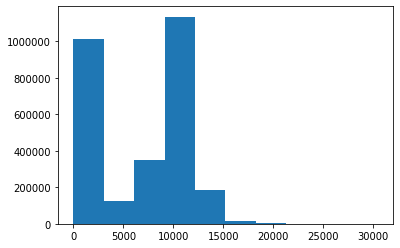

In [14]:
plt.hist(itk_data[mask])

(array([1.012909e+06, 1.252790e+05, 3.481440e+05, 1.135249e+06,
        1.843670e+05, 1.706400e+04, 3.289000e+03, 1.200000e+01,
        7.000000e+00, 4.000000e+00]),
 array([    0.   ,  3045.863,  6091.726,  9137.589, 12183.452, 15229.315,
        18275.178, 21321.041, 24366.904, 27412.768, 30458.63 ],
       dtype=float32),
 <a list of 10 Patch objects>)

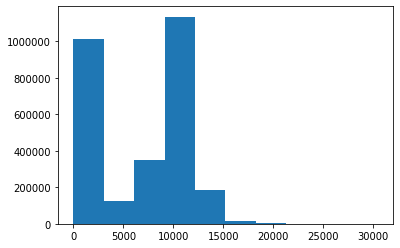

In [15]:
plt.hist(nib_data[mask])

In [12]:
fixed = nib.Nifti1Image(fixed, get_mni152_affine_nib())
pred = nib.Nifti1Image(registered_pred, get_mni152_affine_nib())

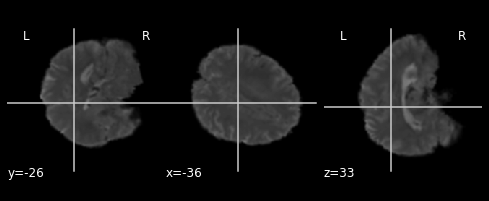

In [13]:
display = plotting.plot_anat(fixed)
display.add_edges(pred)